<a href="https://colab.research.google.com/github/Hadse/special-octo/blob/master/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip3 install torch==1.4.0+cu92 torchvision==0.5.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
BATCH_SIZE = 32
 
#transformerer om til Tensor - slags Numpy-list
transform = transforms.Compose([transforms.ToTensor()])

# laster ned MNIST datasettet som torch har liggende inne. lagrer det i trainset var.  
#Transform = none?
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
# loader dataset, med gitt Batch size.  
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# nå laster vi ned test set, over var det train.
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


In [0]:
class NnGarmentClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        super(NnGarmentClassifier, self).__init__()

        # 28x28x1 => 26x26x32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.d1 = nn.Linear(12 * 4 * 4, 128)
        self.d2 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = x.reshape(-1,12*4*4)
        x = self.d1(x)
        x = F.relu(x)

        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        
        return out

In [0]:
## test the model with 1 batch
model = NnGarmentClassifier()
for images, labels in trainloader:
    out = model(images)
    break

In [0]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = NnGarmentClassifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [8]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)

        logits = logits.view(BATCH_SIZE, -1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i)) 

Epoch: 0 | Loss: 3.8729 | Train Accuracy: 66.33
Epoch: 1 | Loss: 3.7893 | Train Accuracy: 81.35
Epoch: 2 | Loss: 3.7706 | Train Accuracy: 83.91
Epoch: 3 | Loss: 3.7612 | Train Accuracy: 84.97
Epoch: 4 | Loss: 3.7547 | Train Accuracy: 85.68


In [9]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    batch_size = labels.shape[0]
    outputs = model(images)
    outputs = outputs.view(batch_size, -1)
    test_acc += get_accuracy(outputs, labels, batch_size)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 84.81


In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

y_true = []
y_pred = []

for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    outputs = outputs.view(labels.shape[0], -1)
    for label in labels.cpu().numpy():
      y_true.append(label)
    for pred in torch.max(outputs, 1)[1].view(labels.size()).data:
      y_pred.append(pred.data.cpu().numpy())

cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
cm


array([[815,   4,  30,  81,   7,   5,  33,   1,  20,   0],
       [  3, 953,   0,  37,   2,   0,   1,   0,   2,   0],
       [ 18,   1, 824,  14, 105,   2,  23,   0,   5,   0],
       [ 21,  12,  21, 892,  30,   2,  16,   0,   6,   0],
       [  1,   3, 101,  49, 800,   0,  23,   0,  12,   0],
       [  0,   1,   0,   1,   0, 958,   0,  25,   1,  13],
       [216,   4, 165,  52, 134,   0, 380,   0,  34,   1],
       [  0,   0,   0,   0,   0,  34,   0, 930,   0,  34],
       [  1,   1,  13,   7,   4,   5,   3,   5, 958,   0],
       [  0,   0,   0,   0,   0,  10,   0,  46,   1, 942]])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


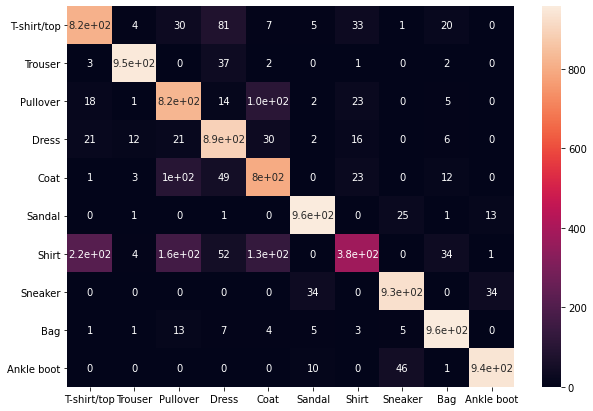

In [11]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in ["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]],
                  columns = [i for i in ["T-shirt/top", "Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)